In [1]:
import torch
from torch import nn

In [2]:
from scripts import muat_datasets
from pathlib import Path

data_path = Path('datasets')
train_dir, test_dir = muat_datasets.muat_data(data_path)

Path dataset sudah benar!


In [3]:
train_dir, test_dir

(WindowsPath('datasets/train'), WindowsPath('datasets/test'))

Direktori gambar: datasets\train\red_rot\redrot (143).jpeg
Class gambar: red_rot
Tinggi gambar: 918
Lebar gambar: 750


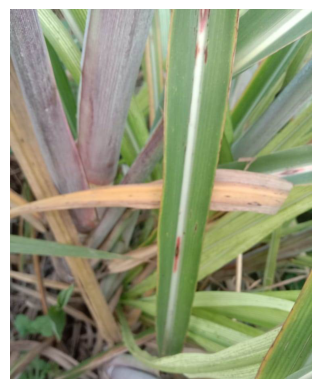

In [4]:
from scripts import visualization

visualization.cek_gambar(data_path)

In [5]:
import torchvision

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
weights = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT
weights

EfficientNet_V2_M_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
from torchvision.transforms import v2

In [10]:
train_transform = v2.Compose([
    # v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.AugMix(),
    v2.TrivialAugmentWide(num_magnitude_bins = 31),
    auto_transforms
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [11]:
train_transform

Compose(
      AugMix(interpolation=InterpolationMode.BILINEAR, severity=3, mixture_width=3, chain_depth=-1, alpha=1.0, all_ops=True)
      TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
      ImageClassification(
      crop_size=[480]
      resize_size=[480]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
)

In [12]:
train_data_loader, test_data_loader, class_names = muat_datasets.dataLoader(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            batch_size = 32, num_workers = 4,
                                                                            train_transform = train_transform,
                                                                            test_transform = auto_transforms)
train_data_loader, test_data_loader, class_names

Membuat DataLoader dengan ukuran batch 32 dan 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2e11a9958e0>,
 ['healthy', 'mosaic', 'red_rot', 'rust', 'yellow'])

In [13]:
image_batch, label_batch = next(iter(train_data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape gambar: torch.Size([3, 480, 480])
Class gambar (bentuk angka): 1


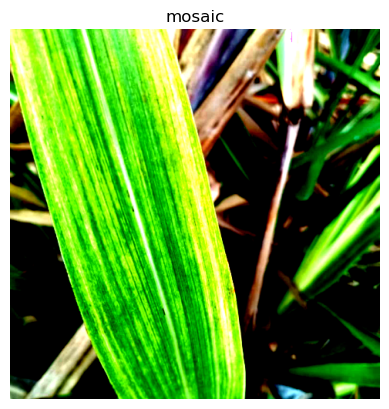

In [14]:
visualization.cek_gambar_dl(image_batch = image_batch, label_batch = label_batch, class_names = class_names)

# EfficientNet V2 Transformer Step-by-Step

In [15]:
model = torchvision.models.efficientnet_v2_m(weights = weights).to(device)

In [16]:
from torchinfo import summary

In [17]:
summary(model = model, 
        input_size=(32, 3, 480, 480), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 480, 480]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 480, 480]    [32, 1280, 15, 15]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 480, 480]    [32, 24, 240, 240]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 480, 480]    [32, 24, 240, 240]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 240, 240]   [32, 24, 240, 240]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 240, 240]   [32, 24, 240, 240]   --                   --
│    └─Sequential (1)                                        [32, 24, 240, 240]   [32, 24, 240

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
from scripts import helper

In [20]:
helper.set_seeds()

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(in_features = 1280, 
                    out_features = output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [21]:
summary(model = model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [23]:
from scripts import engine
# Set the random seeds
helper.set_seeds()

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_data_loader,
                       test_dataloader = test_data_loader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total waktu train: {end_time-start_time:.3f} detik')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3024 | train_acc: 0.5479 | test_loss: 1.1337 | test_acc: 0.6637
Epoch: 2 | train_loss: 0.9301 | train_acc: 0.7107 | test_loss: 0.9482 | test_acc: 0.6883
Epoch: 3 | train_loss: 0.8179 | train_acc: 0.7415 | test_loss: 0.8654 | test_acc: 0.7141
Epoch: 4 | train_loss: 0.7642 | train_acc: 0.7381 | test_loss: 0.8069 | test_acc: 0.7219
Epoch: 5 | train_loss: 0.7256 | train_acc: 0.7589 | test_loss: 0.7581 | test_acc: 0.7305
Epoch: 6 | train_loss: 0.6613 | train_acc: 0.7773 | test_loss: 0.7257 | test_acc: 0.7480
Epoch: 7 | train_loss: 0.6468 | train_acc: 0.7869 | test_loss: 0.7186 | test_acc: 0.7422
Epoch: 8 | train_loss: 0.6373 | train_acc: 0.7820 | test_loss: 0.6916 | test_acc: 0.7383
Epoch: 9 | train_loss: 0.6070 | train_acc: 0.7861 | test_loss: 0.6464 | test_acc: 0.7648
Epoch: 10 | train_loss: 0.6001 | train_acc: 0.7851 | test_loss: 0.6198 | test_acc: 0.7621
Epoch: 11 | train_loss: 0.5959 | train_acc: 0.8021 | test_loss: 0.5898 | test_acc: 0.7789
Epoch: 12 | train_l

In [24]:
PATH = Path('models')
MODEL_NAME = 'EfficientNetV2-M_AutoTransform_AugMix_TrivialAW.pth'

SAVE_PATH = PATH/MODEL_NAME

In [25]:
print(f'Saving model to: {SAVE_PATH}')
torch.save(obj = model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = SAVE_PATH)

Saving model to: models\EfficientNetV2-M_AutoTransform_AugMix_TrivialAW.pth


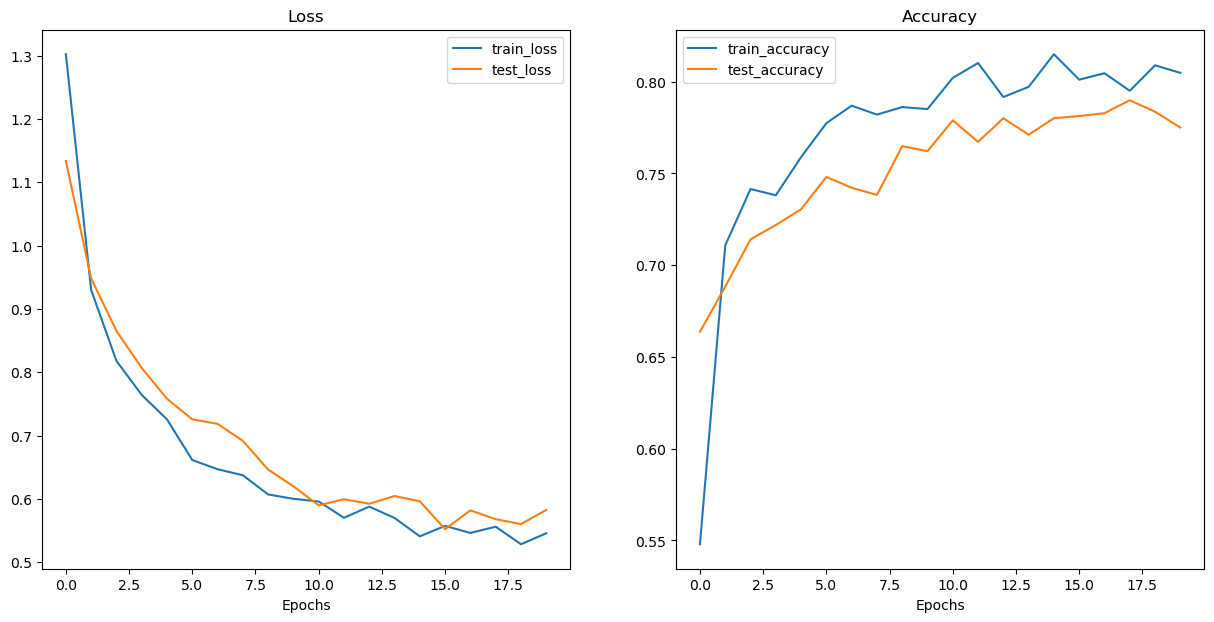

In [26]:
from scripts import prediksi
prediksi.plot_grafik_loss(results)

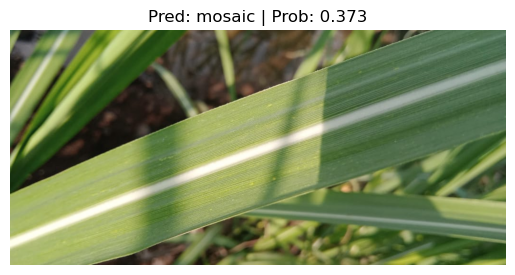

In [27]:
custom_img_path = Path('datasets/test/healthy/healthy (11).jpeg')

prediksi.pred_gambar(model = model,
                image_path = custom_img_path,
                class_names=class_names,
                transform = test_transform,
                device = device)

  0%|          | 0/16 [00:00<?, ?it/s]

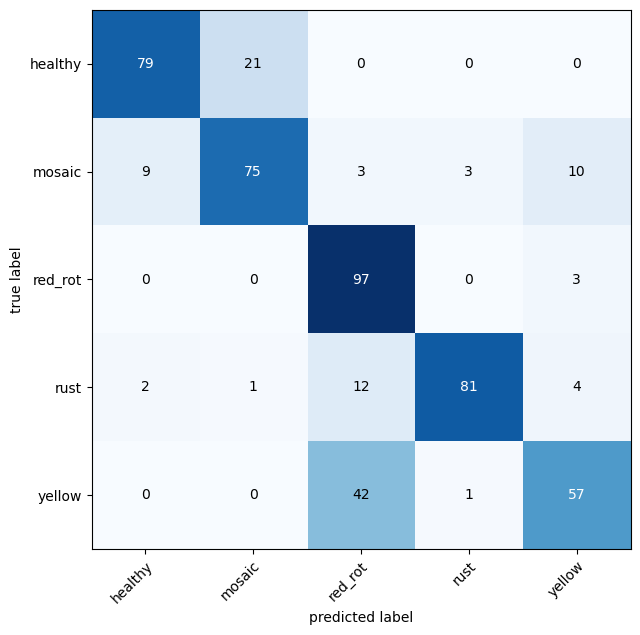

In [28]:
prediksi.confusion_matrix(
    model = model,
    test_dataloader = test_data_loader,
    device = device,
    class_names = class_names
)